<a href="https://colab.research.google.com/github/shreyasrinarasi/finalyearproject/blob/master/working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import datetime

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/My Drive/FinalYearProject/data_use.csv")
df.head()

,DateTime,Voltage,Current,Power,Inv_Temp
0,7/19/2019 6:20,220,45,23,26
1,7/19/2019 6:25,218,59,32,26
2,7/19/2019 6:30,225,68,44,26
3,7/19/2019 6:35,227,82,53,25
4,7/19/2019 6:40,229,105,69,26


# New Section

In [6]:
df.values.shape

(26112, 5)

In [0]:
df['year'] = df.DateTime.map( lambda x: pd.to_datetime(x).year )
df['hour'] = df.DateTime.map( lambda x: pd.to_datetime(x).hour )
df['dayofyear'] = df.DateTime.map( lambda x: pd.to_datetime(x).dayofyear )
df['month'] = df.DateTime.map( lambda x: pd.to_datetime(x).month )
df['minute'] = df.DateTime.map( lambda x: pd.to_datetime(x).minute )

In [8]:
del df['DateTime']
df.head()

,Voltage,Current,Power,Inv_Temp,year,hour,dayofyear,month,minute
0,220,45,23,26,2019,6,200,7,20
1,218,59,32,26,2019,6,200,7,25
2,225,68,44,26,2019,6,200,7,30
3,227,82,53,25,2019,6,200,7,35
4,229,105,69,26,2019,6,200,7,40


In [0]:
shift_days = 1
shift_steps = shift_days * 142

In [0]:
target_names = ['Power']

In [0]:
df_targets = df[target_names].shift(-shift_steps)

In [12]:
df[target_names].head(shift_steps + 5)

,Power
0,23
1,32
2,44
3,53
4,69
...,...
142,38
143,50
144,78
145,64


In [13]:
df_targets.head(5)

,Power
0,38.0
1,50.0
2,78.0
3,64.0
4,63.0


In [14]:
df_targets.tail()

,Power
26107,NaN
26108,NaN
26109,NaN
26110,NaN
26111,NaN


In [0]:
x_data = df.values[0:-shift_steps]

In [16]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 9)


In [0]:
y_data = df_targets.values[:-shift_steps]

In [18]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (25970, 1)


In [19]:
num_data = len(x_data)
num_data

25970

In [0]:
train_split = 0.9

In [21]:
num_train = int(train_split * num_data)
num_train

23373

In [22]:
num_test = num_data - num_train
num_test

2597

In [23]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

25970

In [24]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

25970

In [25]:
num_x_signals = x_data.shape[1]
num_x_signals

9

In [26]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [27]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0
Max: 2020


In [0]:
x_scaler = MinMaxScaler()

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [30]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000004


In [0]:
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [33]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(23373, 9)
(23373, 1)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
batch_size = 32

In [36]:
sequence_length = 142 * 7 * 8
sequence_length

7952

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [39]:
print(x_batch.shape)
print(y_batch.shape)

(32, 7952, 9)
(32, 7952, 1)


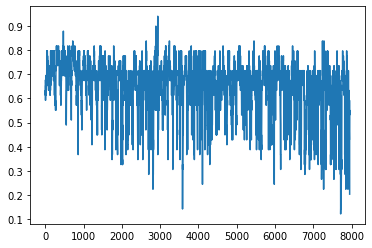

In [40]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

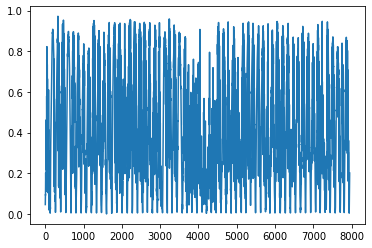

In [41]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

In [0]:
model.add(Dense(units=512,
               input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 50

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 512)         5120      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [55]:
%%time
model.fit(x=generator,
          epochs=1,
          steps_per_epoch=100,
          validation_data=validation_data)

100/100 [==============================] - 54s 541ms/step - loss: 0.0525 - val_loss: 0.0307
CPU times: user 1min 38s, sys: 3.35 s, total: 1min 42s
Wall time: 56.1 s


In [56]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 2ms/step - loss: 0.0307


In [57]:
print("loss (test-set):", result)

loss (test-set): 0.030705835670232773


In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

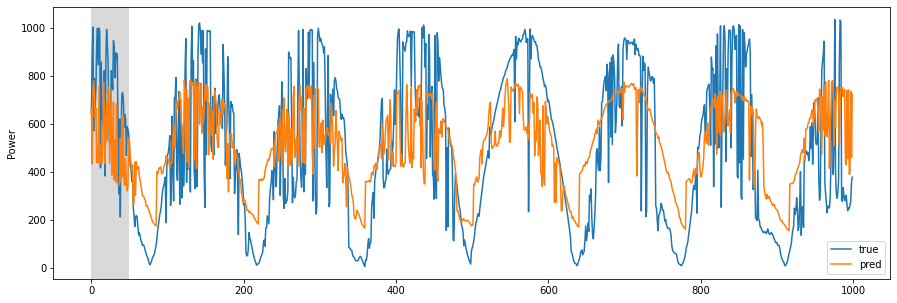

In [66]:
plot_comparison(start_idx=10000, length=1000, train=True)

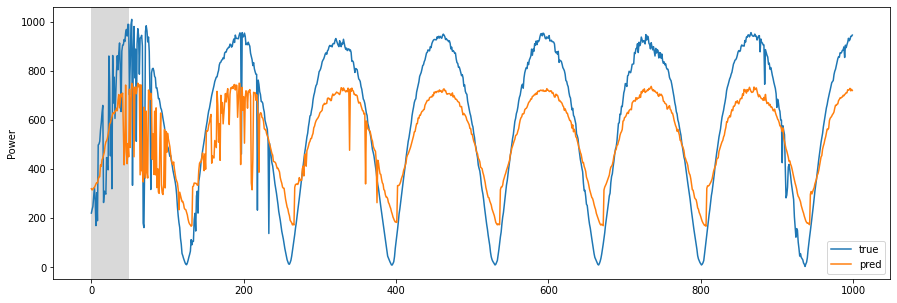

In [69]:
plot_comparison(start_idx=1000, length=1000, train=False)